# Компьютерное зрение. Домашнее задание №3 (HW)
# Николаенко Роман

# Задание

В этом домашнем задании вам необходимо имплементировать процедуру обучения WGAN. 
В качестве датасета предлагается использовать fashion mnist, но вы можете выбрать другой. 
Необходимые моменты (скачивание датасета, базовая модель GAN, базовый цикл обучения и др.) реализованы в ноутбке, который предлагается вам как старт вашей работы. 
В нем же вы найдете полезные ссылки для решения задачи.

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

# Импортирование, настройки и определение функций

In [3]:
# Импортируем модуль `logger` из библиотеки `loguru`

try:
    from loguru import logger
except ModuleNotFoundError:
    !pip install loguru
finally:
    from loguru import logger

In [4]:
# Импортируем необходимые библиотеки

import os
from pathlib import Path

import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable, grad

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# DATA_FOLDER = os.path.abspath("/content/drive/MyDrive/HW_URFU/CV/HW3/models")
# MODELS_FOLDER = os.path.join(DATA_FOLDER, "models")

MODELS_FOLDER = os.path.abspath("/content/drive/MyDrive/HW_URFU/CV/HW3/models") # Введите свой путь, если необходимо
Path(MODELS_FOLDER).mkdir(exist_ok=True, parents=True)


DISCRIMINATOR_0_PATH = os.path.join(MODELS_FOLDER, "discriminator_0.pth")
GENERATOR_0_PATH = os.path.join(MODELS_FOLDER, "generator_0.pth")
ERRG_0_PATH = os.path.join(MODELS_FOLDER, "ERRG_0.npy")
ERRD_X_0_PATH = os.path.join(MODELS_FOLDER, "ERRD_x_0.npy")
ERRD_Z_0_PATH = os.path.join(MODELS_FOLDER, "ERRD_z_0.npy")

DISCRIMINATOR_1_PATH = os.path.join(MODELS_FOLDER, "discriminator_1.pth")
GENERATOR_1_PATH = os.path.join(MODELS_FOLDER, "generator_1.pth")
ERRG_1_PATH = os.path.join(MODELS_FOLDER, "ERRG_1.npy")
ERRD_X_1_PATH = os.path.join(MODELS_FOLDER, "ERRD_x_1.npy")
ERRD_Z_1_PATH = os.path.join(MODELS_FOLDER, "ERRD_z_1.npy")

DISCRIMINATOR_2_PATH = os.path.join(MODELS_FOLDER, "discriminator_2.pth")
GENERATOR_2_PATH = os.path.join(MODELS_FOLDER, "generator_2.pth")
ERRG_2_PATH = os.path.join(MODELS_FOLDER, "ERRG_2.npy")
ERRD_X_2_PATH = os.path.join(MODELS_FOLDER, "ERRD_x_2.npy")
ERRD_Z_2_PATH = os.path.join(MODELS_FOLDER, "ERRD_z_2.npy")

DISCRIMINATOR_3_PATH = os.path.join(MODELS_FOLDER, "discriminator_3.pth")
GENERATOR_3_PATH = os.path.join(MODELS_FOLDER, "generator_3.pth")
ERRG_3_PATH = os.path.join(MODELS_FOLDER, "ERRG_3.npy")
ERRD_X_3_PATH = os.path.join(MODELS_FOLDER, "ERRD_x_3.npy")
ERRD_Z_3_PATH = os.path.join(MODELS_FOLDER, "ERRD_z_3.npy")


class Config:
    pass

config = Config()
config.train_model = False # False, если модели уже существуют
config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"device = {config.device}")
device = config.device
config.mnist_path = None
config.batch_size = 16
config.num_workers = -1
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 500
config.clip_value = 0.01
config.n_critic = 5
config.num_classes = 10
config.lr = 0.0001
config.lambda_gp = 1
config.embedding_size = 50
config.betas = (0.5, 0.999)
config.len_dataloader = 3750


def imshow(img):
    npimg = np.clip(img.numpy(), 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def gen_and_show(noise, generator, labels=None, cmap="YlGnBu_r"):
    noise.data.normal_(0, 1)
    if labels == None:
        fake = generator(noise)
    else:
        fake = generator(noise, labels)

    plt.figure(figsize=(6, 7))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(
            fake[i].cpu().detach().numpy().reshape(28, 28),
            cmap=cmap,
        )
        plt.axis('off')


def output_label(label):
    output_mapping = {
        0: "T-shirt/Top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

def gen_and_show_cond(noise, generator, label_number, cmap="YlGnBu_r"):
    cond_labels = torch.tensor([label_number for _ in range(16)]).to(device)
    gen_and_show(noise, generator, cond_labels, cmap)
    print(output_label(label_number))


def plot_err(errg, errd_x, errd_z):
    fig, ax = plt.subplots(sharex=True, figsize=(7, 5))
    for array, name in zip(
        [errg, errd_x, errd_z],
        ["ERRG", "ERRD_x", "ERRD_z"],
    ):
        ax.plot(
            array / config.len_dataloader,
            label=name,
        )
    ax.set_ylabel("Error")
    ax.set_xlabel("Epoch")
    ax.legend();

device = cpu


# Dataloader

In [5]:
# Загрузим набор данных FashionMNIST с помощью библиотеки torchvision

train = torchvision.datasets.FashionMNIST(
    "fashion_mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

100%|██████████| 26421880/26421880 [00:03<00:00, 7737341.24it/s]


Extracting fashion_mnist\FashionMNIST\raw\train-images-idx3-ubyte.gz to fashion_mnist\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 668496.64it/s]


Extracting fashion_mnist\FashionMNIST\raw\train-labels-idx1-ubyte.gz to fashion_mnist\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4330098.72it/s]


Extracting fashion_mnist\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to fashion_mnist\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<00:00, 1152571.63it/s]

Extracting fashion_mnist\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to fashion_mnist\FashionMNIST\raw



In [6]:
# Создадим объект DataLoader для обработки данных

dataloader = DataLoader(
    train,
    batch_size=16,
    shuffle=True,
)
config.len_dataloader = len(dataloader)
config.len_dataloader

3750

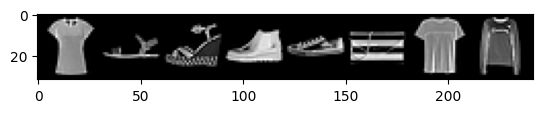

torch.Size([16, 1, 28, 28])
T-shirt/top
Sandal
Sandal
Ankle boot
Sneaker
Bag  
T-shirt/top
Pullover


In [7]:
# Посмотрим изображения из набора данных

image, label = next(iter(dataloader))
NUM_IMAGES = 8
imshow(torchvision.utils.make_grid(image[:NUM_IMAGES]))
print(image.size())
print('\n'.join(f'{train.classes[label[:NUM_IMAGES][j]]:5s}' for j in range(NUM_IMAGES)))

# 1. Baseline

В данном разделе мы рассмотрим базовую модель из представленного блокнота-примера, чтобы оценить, как наши последующие изменения повлияли на генерацию.

### Генеративно-состязательная сеть (GAN)

In [8]:
# Создаем модель GAN

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return self.model(x)

generator_0 = Generator().to(device)
discriminator_0 = Discriminator().to(device)

In [9]:
# Оптимизатор, функция потерь, переменные

optim_G = optim.Adam(params=generator_0.parameters(), lr=config.lr)
optim_D = optim.Adam(params=discriminator_0.parameters(), lr=config.lr)

criterion = nn.BCELoss()

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
label = Variable(torch.FloatTensor(config.batch_size)).to(device)
real_label = 1
fake_label = 0

In [10]:
# Обучение с помощью GAN

if config.train_model:
    logger.debug(f"config.train_model = {config.train_model}")
    logger.info("Start model_0 training")

    ERRD_x_0 = np.zeros(config.num_epochs)
    ERRD_z_0 = np.zeros(config.num_epochs)
    ERRG_0 = np.zeros(config.num_epochs)
    N = len(dataloader)

    for epoch in range(config.num_epochs):
        for iteration, (images, _) in enumerate(dataloader):
            #######
            # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z)))
            #######
            discriminator_0.zero_grad()

            # real
            label.data.fill_(real_label)
            input_data = images.view(images.shape[0], -1).to(device)
            output = discriminator_0(input_data).view(-1)
            errD_x = criterion(output, label)
            ERRD_x_0[epoch] += errD_x.item()
            errD_x.backward()

            # fake
            noise.data.normal_(0, 1)
            fake = generator_0(noise)
            label.data.fill_(fake_label)
            output = discriminator_0(fake.detach()).view(-1)
            errD_z = criterion(output, label)
            ERRD_z_0[epoch] += errD_z.item()
            errD_z.backward()

            optim_D.step()

            #######
            # Generator stage: maximize log(D(G(x))
            #######
            generator_0.zero_grad()
            label.data.fill_(real_label)
            output = discriminator_0(fake).view(-1)
            errG = criterion(output, label)
            ERRG_0[epoch] += errG.item()
            errG.backward()

            optim_G.step()

            if (iteration+1) % config.print_freq == 0:
                logger.info(
                    "Epoch:{}/{} Iter: {}/{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}".format(
                        epoch + 1,
                        config.num_epochs,
                        iteration + 1,
                        config.len_dataloader,
                        errD_x.item(),
                        errD_z.item(),
                        errG.item(),
                    ),
                )
    logger.success("Train is done")

    # save models and metrics
    torch.save(discriminator_0, DISCRIMINATOR_0_PATH)
    torch.save(generator_0, GENERATOR_0_PATH)
    np.save(ERRG_0_PATH, ERRG_0)
    np.save(ERRD_X_0_PATH, ERRD_x_0)
    np.save(ERRD_Z_0_PATH, ERRD_z_0)
    logger.success("All models and metrics were saved for model_0")
else:
    logger.debug(f"config.train_model = {config.train_model}")
    discriminator_0 = torch.load(DISCRIMINATOR_0_PATH)
    generator_0 = torch.load(GENERATOR_0_PATH)
    ERRG_0 = np.load(ERRG_0_PATH)
    ERRD_x_0 = np.load(ERRD_X_0_PATH)
    ERRD_z_0 = np.load(ERRD_Z_0_PATH)
    logger.success("All models and metrics were loaded for model_0")

2023-12-30 03:13:21.453 | DEBUG    | __main__:<module>:72 - config.train_model = False
2023-12-30 03:13:21.478 | SUCCESS  | __main__:<module>:78 - All models and metrics were loaded for model_0


Тренировочные логи:
```log
2023-12-26 19:28:35.547 | DEBUG    | __main__:<cell line: 1>:2 - config.train_model = True
2023-12-26 19:28:35.549 | INFO     | __main__:<cell line: 1>:3 - Start model_0 training
2023-12-26 19:28:40.369 | INFO     | __main__:<cell line: 1>:48 - Epoch:1/10 Iter: 500/3750 errD_x: 0.13 errD_z: 0.04 errG: 3.30
2023-12-26 19:28:46.004 | INFO     | __main__:<cell line: 1>:48 - Epoch:1/10 Iter: 1000/3750 errD_x: 0.10 errD_z: 0.22 errG: 2.09
...
2023-12-26 19:35:26.285 | INFO     | __main__:<cell line: 1>:48 - Epoch:10/10 Iter: 3500/3750 errD_x: 0.38 errD_z: 0.06 errG: 3.46
2023-12-26 19:35:30.161 | SUCCESS  | __main__:<cell line: 1>:59 - Train is done
2023-12-26 19:35:30.199 | SUCCESS  | __main__:<cell line: 1>:67 - All models and metrics were saved for model_0
```

Посмотрим изображения.

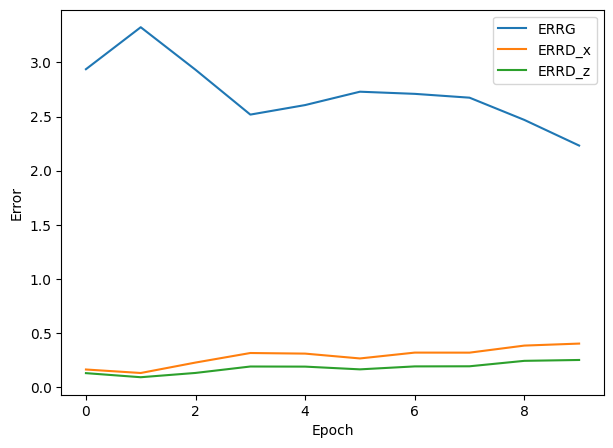

In [11]:
# Создадим график ошибок 

plot_err(ERRG_0, ERRD_x_0, ERRD_z_0)

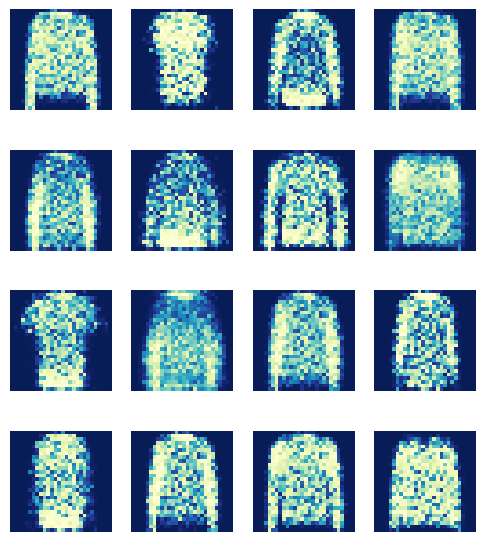

In [12]:
# Генерация

gen_and_show(noise, generator_0)

# Вывод

Хотя базовая реализация привела к шумным изображениям, все же некоторые формы можно различить, и контуры четкие. Все еще достойный результат, посмотрим, сможем ли его улучшить.

# 2. WGAN + Clip

* Реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

1. В архитектуре сети нужно изменить функцию работы дискриминатора, убрав сигмоид-активацию. Это связано с тем, что WGAN использует линейный выходной сигнал для вычисления непрерывного и неограниченного значения критической функции (в литературе WGAN она называется "критик" вместо "дискриминатора").

2. Во время цикла обучения нужно добавить клиппинг после обновления весов дискриминатора (критика). Это достигается путем ограничения значений весов в узком диапазоне [-clip, clip], где clip - малое дробное число между 0 и 1 (например, 0.01).

3. Перед началом цикла обучения необходимо изменить функцию потерь как для генератора, так и для дискриминатора: WGAN использует потери Вассерштейна, которые представляют собой разницу между средним значением критической функции для реальных данных и средним значением критической функции для сгенерированных (фейковых) данных для дискриминатора, а для генератора - отрицательное среднее значение критической функции для сгенерированных данных.


### Генеративно-состязательная сеть Вассерштейна (WGAN)

In [13]:
# Создаем модель WGAN

class WGeneratorClip(nn.Module):
    def __init__(self):
        super(WGeneratorClip, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class WDiscriminatorClip(nn.Module):
    def __init__(self):
        super(WDiscriminatorClip, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            # delite nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


generator_1 = WGeneratorClip().to(device)
discriminator_1 = WDiscriminatorClip().to(device)

In [14]:
# Оптимизаторы RMSprop и переменные

optim_G = optim.RMSprop(params=generator_1.parameters(), lr=config.lr)
optim_D = optim.RMSprop(params=discriminator_1.parameters(), lr=config.lr)

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
label = Variable(torch.FloatTensor(config.batch_size)).to(device)
real_label = 1
fake_label = 0

In [15]:
# WGAN + Clipping обучение модели

if config.train_model:
    logger.debug(f"config.train_model = {config.train_model}")
    logger.info("Start model_1 training")

    ERRD_x_1 = np.zeros(config.num_epochs)
    ERRD_z_1 = np.zeros(config.num_epochs)
    ERRG_1 = np.zeros(config.num_epochs)
    N = len(dataloader)

    config.clip_value = 0.01

    for epoch in range(config.num_epochs):
        for iteration, (images, _) in enumerate(dataloader):
            #######
            # Critic/Discriminator stage: maximize E[D(x)] - E[D(G(z))]
            #######
            discriminator_1.zero_grad()

            # real
            real_images = images.view(images.shape[0], -1).to(device)
            errD_x = -torch.mean(discriminator_1(real_images))
            ERRD_x_1[epoch] += errD_x.item()
            errD_x.backward()

            # fake
            noise.data.normal_(0, 1)
            fake_images = generator_1(noise)
            errD_z = torch.mean(discriminator_1(fake_images.detach()))
            ERRD_z_1[epoch] += errD_z.item()
            errD_z.backward()

            # clipping
            optim_D.step()
            for p in discriminator_1.parameters():
                p.data.clamp_(-config.clip_value, config.clip_value)

            #######
            # Generator stage: minimize -E[D(G(z))]
            #######
            generator_1.zero_grad()
            output = discriminator_1(fake_images).view(-1)
            errG = -torch.mean(output)
            ERRG_1[epoch] += errG.item()
            errG.backward()

            optim_G.step()

            if (iteration+1) % config.print_freq == 0:
                logger.info(
                    "Epoch:{}/{} Iter: {}/{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}".format(
                        epoch + 1,
                        config.num_epochs,
                        iteration + 1,
                        config.len_dataloader,
                        errD_x.item(),
                        errD_z.item(),
                        errG.item(),
                    ),
                )
    logger.success("Train is done")

    # save models and metrics
    torch.save(discriminator_1, DISCRIMINATOR_1_PATH)
    torch.save(generator_1, GENERATOR_1_PATH)
    np.save(ERRG_1_PATH, ERRG_1)
    np.save(ERRD_X_1_PATH, ERRD_x_1)
    np.save(ERRD_Z_1_PATH, ERRD_z_1)
    logger.success("All models and metrics were saved for model_1")
else:
    logger.debug(f"config.train_model = {config.train_model}")
    discriminator_1 = torch.load(DISCRIMINATOR_1_PATH)
    generator_1 = torch.load(GENERATOR_1_PATH)
    ERRG_1 = np.load(ERRG_1_PATH)
    ERRD_x_1 = np.load(ERRD_X_1_PATH)
    ERRD_z_1 = np.load(ERRD_Z_1_PATH)
    logger.success("All models and metrics were loaded for model_1")

2023-12-30 03:13:23.696 | DEBUG    | __main__:<module>:72 - config.train_model = False
2023-12-30 03:13:23.713 | SUCCESS  | __main__:<module>:78 - All models and metrics were loaded for model_1


Тренировочные логи:
```log
2023-12-26 19:36:49.885 | DEBUG    | __main__:<cell line: 1>:2 - config.train_model = True
2023-12-26 19:36:49.886 | INFO     | __main__:<cell line: 1>:3 - Start model_1 training
2023-12-26 19:36:54.555 | INFO     | __main__:<cell line: 1>:48 - Epoch:1/10 Iter: 500/3750 errD_x: -0.13 errD_z: 0.01 errG: -0.01
2023-12-26 19:36:58.563 | INFO     | __main__:<cell line: 1>:48 - Epoch:1/10 Iter: 1000/3750 errD_x: -0.08 errD_z: 0.02 errG: -0.02
2023-12-26 19:37:03.601 | INFO     | __main__:<cell line: 1>:48 - Epoch:1/10 Iter: 1500/3750 errD_x: -0.02 errD_z: -0.00 errG: 0.00
...
2023-12-26 19:42:47.093 | INFO     | __main__:<cell line: 1>:48 - Epoch:10/10 Iter: 3500/3750 errD_x: -0.03 errD_z: 0.04 errG: -0.03
2023-12-26 19:42:50.024 | SUCCESS  | __main__:<cell line: 1>:59 - Train is done
2023-12-26 19:42:50.088 | SUCCESS  | __main__:<cell line: 1>:67 - All models and metrics were saved for model_1
```

Изображения.

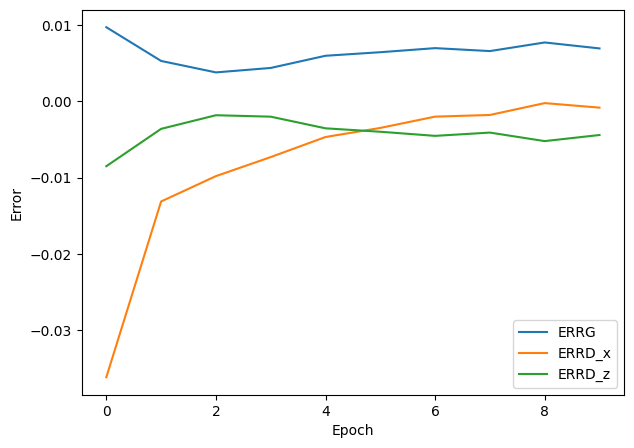

In [16]:
# Создадим график ошибок 

plot_err(ERRG_1, ERRD_x_1, ERRD_z_1)

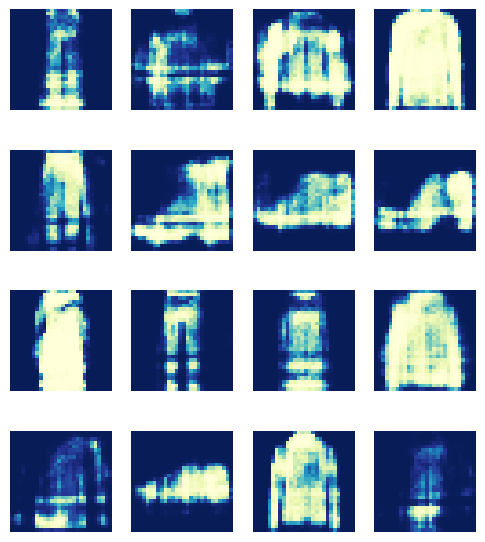

In [17]:
# Генерация

gen_and_show(noise, generator_1)

## Вывод

1. В сравнении с базовой моделью, мы замечаем значительное уменьшение шума при использовании WGAN + Clipping.
2. Многие изображения, созданные с помощью этого метода, отличаются красивой детализацией.
3. В то же время, некоторые изображения страдают от потери яркости, что затрудняет их разглядывание. Некоторые изображения также имеют явно пересвеченные области.

# 3. WGAN-GP

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

# Генеративно-состязательная сеть Вассерштейна с градиентным штрафом (WGAN-GP)

In [18]:
# Копируем модель из предыдущей секции

class WGenerator(nn.Module):
    def __init__(self):
        super(WGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

class WDiscriminator(nn.Module):
    def __init__(self):
        super(WDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1),
            # delite nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


generator_2 = WGenerator().to(device)
discriminator_2 = WDiscriminator().to(device)

In [19]:
# Задаём функцию для рассчета градиентов 

def calculate_gradient_penalty(
    discriminator,
    real_samples,
    fake_samples,
    device,
    labels=None,
):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(real_samples.size())
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.requires_grad_(True)

    if labels is not None:
        d_interpolates = discriminator(interpolates, labels)
    else:
        d_interpolates = discriminator(interpolates)

    fake = Variable(
        torch.ones(
            d_interpolates.size(),
            device=device,
        ),
        requires_grad=False,
    )

    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * config.lambda_gp
    return gradient_penalty

In [20]:
# Оптимизаторы RMSprop и переменные

optim_G = optim.RMSprop(params=generator_2.parameters(), lr=config.lr)
optim_D = optim.RMSprop(params=discriminator_2.parameters(), lr=config.lr)

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size)).to(device)
label = Variable(torch.FloatTensor(config.batch_size)).to(device)
real_label = 1
fake_label = 0

In [21]:
# WGAN-GP обучение

if config.train_model:
    logger.debug(f"config.train_model = {config.train_model}")
    logger.info("Start model_2 training")

    ERRD_x_2 = np.zeros(config.num_epochs)
    ERRD_z_2 = np.zeros(config.num_epochs)
    ERRG_2 = np.zeros(config.num_epochs)

    for epoch in range(config.num_epochs):
        for iteration, (images, _) in enumerate(dataloader):
            # Critic/Discriminator stage with gradient penalty
            discriminator_2.zero_grad()

            # real
            real_images = images.view(images.shape[0], -1).to(device)
            d_real = discriminator_2(real_images)
            errD_real = -torch.mean(d_real)

            # fake
            noise.data.normal_(0, 1)
            fake_images = generator_2(noise)
            d_fake = discriminator_2(fake_images.detach())
            errD_fake = torch.mean(d_fake)

            # gradient penalty
            gradient_penalty = calculate_gradient_penalty(
                discriminator_2,
                real_images.data,
                fake_images.data,
                device,
            )

            # discriminator_2 loss
            errD = errD_real + errD_fake + gradient_penalty
            errD.backward()
            optim_D.step()

            ERRD_x_2[epoch] -= errD_real.item()
            ERRD_z_2[epoch] += errD_fake.item()

            # Generator stage
            if (iteration + 1) % config.n_critic == 0:
                generator_2.zero_grad()
                d_fake_gen = discriminator_2(fake_images)
                errG = -torch.mean(d_fake_gen)
                errG.backward()
                optim_G.step()
                ERRG_2[epoch] += errG.item()

            if (iteration + 1) % config.print_freq == 0:
                logger.info(
                    "Epoch:{}/{} Iter: {}/{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}".format(
                        epoch + 1,
                        config.num_epochs,
                        iteration + 1,
                        config.len_dataloader,
                        errD_x.item(),
                        errD_z.item(),
                        errG.item(),
                    ),
                )
    logger.success("Train is done")

    # save models and metrics
    torch.save(discriminator_2, DISCRIMINATOR_2_PATH)
    torch.save(generator_2, GENERATOR_2_PATH)
    np.save(ERRG_2_PATH, ERRG_2)
    np.save(ERRD_X_2_PATH, ERRD_x_2)
    np.save(ERRD_Z_2_PATH, ERRD_z_2)
    logger.success("All models and metrics were saved for model_2")
else:
    logger.debug(f"config.train_model = {config.train_model}")
    discriminator_2 = torch.load(DISCRIMINATOR_2_PATH)
    generator_2 = torch.load(GENERATOR_2_PATH)
    ERRG_2 = np.load(ERRG_2_PATH)
    ERRD_x_2 = np.load(ERRD_X_2_PATH)
    ERRD_z_2 = np.load(ERRD_Z_2_PATH)
    logger.success("All models and metrics were loaded for model_2")

2023-12-30 03:13:25.796 | DEBUG    | __main__:<module>:74 - config.train_model = False
2023-12-30 03:13:25.827 | SUCCESS  | __main__:<module>:80 - All models and metrics were loaded for model_2


Тренировочные логи:
```log
2023-12-26 20:01:25.492 | DEBUG    | __main__:<cell line: 1>:2 - config.train_model = True
2023-12-26 20:01:25.496 | INFO     | __main__:<cell line: 1>:3 - Start model_2 training
2023-12-26 20:01:31.351 | INFO     | __main__:<cell line: 1>:51 - Epoch:1/10 Iter: 500/3750 errD_x: -0.02 errD_z: 0.01 errG: 10.16
2023-12-26 20:01:36.975 | INFO     | __main__:<cell line: 1>:51 - Epoch:1/10 Iter: 1000/3750 errD_x: -0.02 errD_z: 0.01 errG: 2.78
2023-12-26 20:01:42.473 | INFO     | __main__:<cell line: 1>:51 - Epoch:1/10 Iter: 1500/3750 errD_x: -0.02 errD_z: 0.01 errG: 1.24
...
2023-12-26 20:08:00.033 | SUCCESS  | __main__:<cell line: 1>:69 - All models and metrics were saved for model_2
```

Изображения.

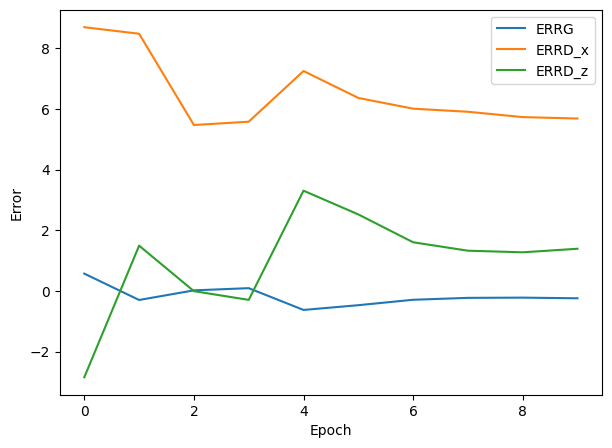

In [22]:
# Построим график ошибок

plot_err(ERRG_2, ERRD_x_2, ERRD_z_2)

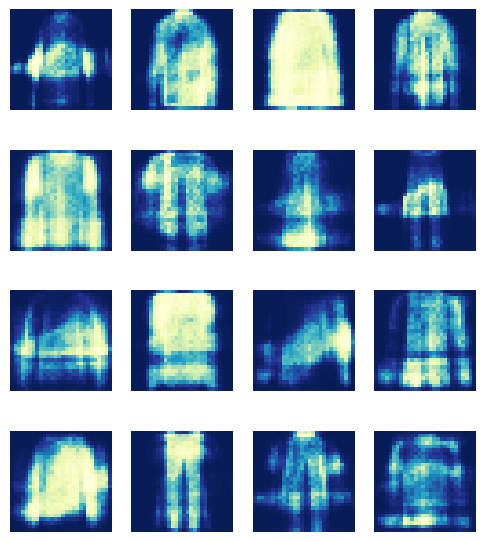

In [23]:
# Генерация

gen_and_show(noise, generator_2)

## Вывод

Наблюдается следующая ситуация в случае использования WGAN-GP:
1. По сравнению с базовой моделью мы замечаем значительное снижение уровня шумов (как и при использовании клиппинга).
2. В сравнении с клиппингом мы наблюдаем меньшую резкость изображений. Многие из них имеют детали, но в некоторых областях они светлые. Однако, формы лучше предсказываются, по моему мнению.
3. Все еще есть некоторые изображения (или их фрагменты), которые слишком тусклые.

# 4. CWGAN-GP



* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)



## Условная генеративно-состязательная сеть Вассерштейна с градиентным штрафом (CWGAN-GP)

Копируем уже известную функцию для более удобного запуска:

In [24]:
# Повторим функцию, чтобы сделать ее запуск более удобным

def calculate_gradient_penalty(
    discriminator,
    real_samples,
    fake_samples,
    device,
    labels=None,
):
    batch_size = real_samples.size(0)
    alpha = torch.rand(batch_size, 1, device=device)
    alpha = alpha.expand(real_samples.size())
    interpolates = alpha * real_samples + ((1 - alpha) * fake_samples)
    interpolates = interpolates.requires_grad_(True)

    if labels is not None:
        d_interpolates = discriminator(interpolates, labels)
    else:
        d_interpolates = discriminator(interpolates)

    fake = Variable(
        torch.ones(
            d_interpolates.size(),
            device=device,
        ),
        requires_grad=False,
    )

    gradients = grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * config.lambda_gp
    return gradient_penalty

In [25]:
# Определим классы в контексте CWGAN

class CWGenerator(nn.Module):
    def __init__(self):
        super(CWGenerator, self).__init__()

        self.label_emb = nn.Embedding(config.num_classes, config.embedding_size)

        self.model = nn.Sequential(
            nn.Linear(config.noise_size + config.embedding_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28 * 28),
            nn.Sigmoid()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        return self.model(x)

class CWDiscriminator(nn.Module):
    def __init__(self):
        super(CWDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(config.num_classes, config.embedding_size)

        self.model = nn.Sequential(
            nn.Linear(28 * 28 + config.embedding_size, 200),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(200, 50),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(50, 1),
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.view(c.size(0), -1)
        x = x.view(x.size(0), -1)
        x = torch.cat([x, c], 1)
        return self.model(x)


generator_3 = CWGenerator().to(device)
discriminator_3 = CWDiscriminator().to(device)

In [26]:
# Оптимизаторы и переменные

optim_G = torch.optim.Adam(
    generator_3.parameters(),
    lr=config.lr,
    betas=config.betas,
)

optim_D = torch.optim.Adam(
    discriminator_3.parameters(),
    lr=config.lr,
    betas=config.betas,
)
real_label = 1
fake_label = 0

In [27]:
# Обучим модель CWGAN-GP с использованием лейблов

if config.train_model:
    logger.debug(f"config.train_model = {config.train_model}")
    logger.info("Start model_3 training")

    ERRD_x_3 = np.zeros(config.num_epochs)
    ERRD_z_3 = np.zeros(config.num_epochs)
    ERRG_3 = np.zeros(config.num_epochs)

    for epoch in range(config.num_epochs):
        for iteration, (images, labels) in enumerate(dataloader):
            batch_size = images.size(0)

            # Prepare inputs
            real_images = images.view(batch_size, -1).to(device)
            labels = labels.to(device)
            noise = torch.randn(
                config.batch_size,
                config.noise_size,
                device=device,
            )
            fake_labels = torch.randint(
                0,
                config.num_classes,
                (batch_size,),
                device=device,
            )

            # Critic/Discriminator stage with gradient penalty
            for _ in range(config.n_critic):
                discriminator_3.zero_grad()

                # real
                d_real = discriminator_3(real_images, labels)
                errD_real = -torch.mean(d_real)

                # fake
                fake_images = generator_3(noise, fake_labels)
                d_fake = discriminator_3(fake_images.detach(), fake_labels)
                errD_fake = torch.mean(d_fake)

                gradient_penalty = calculate_gradient_penalty(
                    discriminator_3,
                    real_images.data,
                    fake_images.data,
                    device,
                    labels,
                )

                # discriminator_3 loss
                errD = errD_real + errD_fake + gradient_penalty
                errD.backward()
                optim_D.step()

            ERRD_x_3[epoch] -= errD_real.item()
            ERRD_z_3[epoch] += errD_fake.item()

            # Generator stage
            if (iteration + 1) % config.n_critic == 0:
                generator_3.zero_grad()
                # Generate new fake images and compute loss for generator_3
                generated_images = generator_3(noise, fake_labels)
                d_fake_gen = discriminator_3(generated_images, fake_labels)
                errG = -torch.mean(d_fake_gen)
                errG.backward()
                optim_G.step()
                ERRG_3[epoch] += errG.item()

            if (iteration + 1) % config.print_freq == 0:
                logger.info(
                    "Epoch:{}/{} Iter: {}/{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}".format(
                        epoch + 1,
                        config.num_epochs,
                        iteration + 1,
                        config.len_dataloader,
                        errD_real.item(),
                        errD_fake.item(),
                        errG.item(),
                    ),
                )
    logger.success("Train is done")

    # save models and metrics
    torch.save(discriminator_3, DISCRIMINATOR_3_PATH)
    torch.save(generator_3, GENERATOR_3_PATH)
    np.save(ERRG_3_PATH, ERRG_3)
    np.save(ERRD_X_3_PATH, ERRD_x_3)
    np.save(ERRD_Z_3_PATH, ERRD_z_3)
    logger.success("All models and metrics were saved for model_3")
else:
    logger.debug(f"config.train_model = {config.train_model}")
    discriminator_3 = torch.load(
        DISCRIMINATOR_3_PATH,
        map_location=torch.device('cpu'),
    )
    generator_3 = torch.load(
        GENERATOR_3_PATH,
        map_location=torch.device('cpu'),
    )
    ERRG_3 = np.load(ERRG_3_PATH)
    ERRD_x_3 = np.load(ERRD_X_3_PATH)
    ERRD_z_3 = np.load(ERRD_Z_3_PATH)
    logger.success("All models and metrics were loaded for model_3")

2023-12-30 03:13:27.891 | DEBUG    | __main__:<module>:92 - config.train_model = False
2023-12-30 03:13:27.927 | SUCCESS  | __main__:<module>:104 - All models and metrics were loaded for model_3


Тренировочные логи:
```log
2023-12-26 20:20:46.430 | DEBUG    | __main__:<cell line: 1>:2 - config.train_model = True
2023-12-26 20:20:46.432 | INFO     | __main__:<cell line: 1>:3 - Start model_3 training
2023-12-26 20:20:58.669 | INFO     | __main__:<cell line: 1>:69 - Epoch:1/10 Iter: 500/3750 errD_x: -3.13 errD_z: -21.38 errG: 21.48
2023-12-26 20:21:10.535 | INFO     | __main__:<cell line: 1>:69 - Epoch:1/10 Iter: 1000/3750 errD_x: -9.19 errD_z: -5.22 errG: 5.48
2023-12-26 20:21:23.273 | INFO     | __main__:<cell line: 1>:69 - Epoch:1/10 Iter: 1500/3750 errD_x: -7.81 errD_z: -3.30 errG: 3.37
...
2023-12-26 20:37:05.186 | INFO     | __main__:<cell line: 1>:69 - Epoch:10/10 Iter: 3500/3750 errD_x: -14.90 errD_z: 7.32 errG: -6.99
2023-12-26 20:37:11.140 | SUCCESS  | __main__:<cell line: 1>:80 - Train is done
2023-12-26 20:37:11.193 | SUCCESS  | __main__:<cell line: 1>:88 - All models and metrics were saved for model_3
```

Изображения.

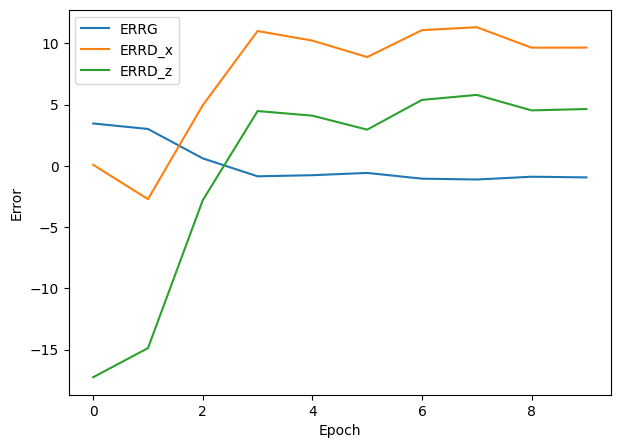

In [28]:
# Построим график ошибок

plot_err(ERRG_3, ERRD_x_3, ERRD_z_3)

T-shirt/Top


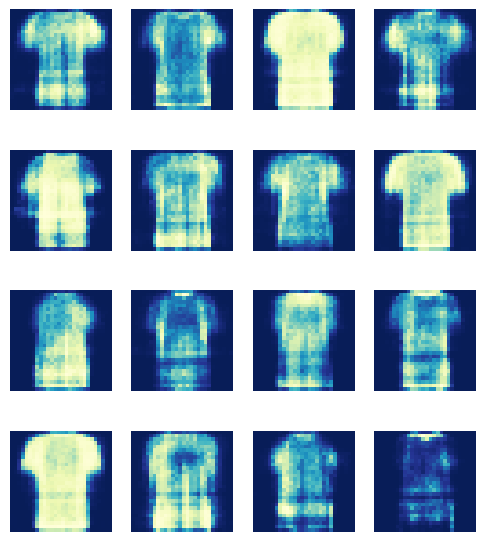

In [29]:
# Генерация

gen_and_show_cond(noise, generator_3, 0)

Trouser


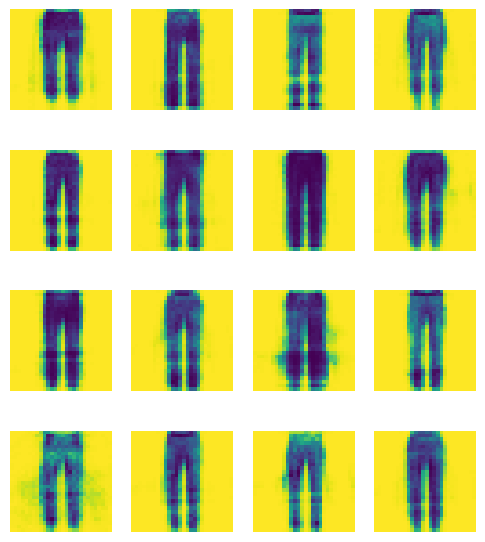

In [30]:
# Генерация

gen_and_show_cond(noise, generator_3, 1, cmap="viridis_r")

Pullover


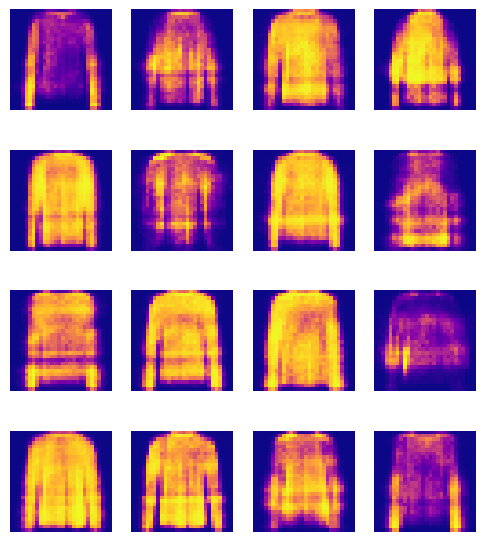

In [31]:
# Генерация

gen_and_show_cond(noise, generator_3, 2, cmap="plasma")

Dress


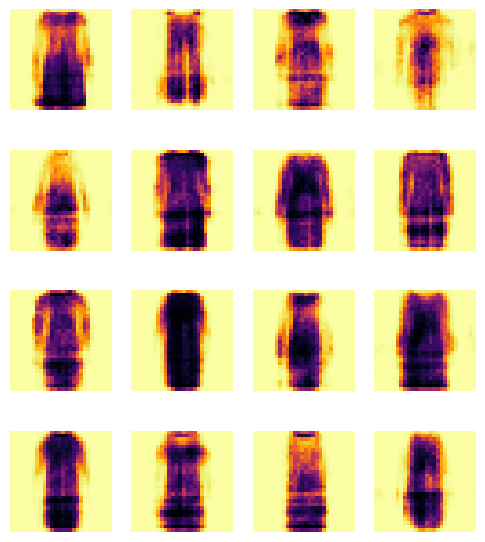

In [32]:
# Генерация

gen_and_show_cond(noise, generator_3, 3, cmap="inferno_r")

Coat


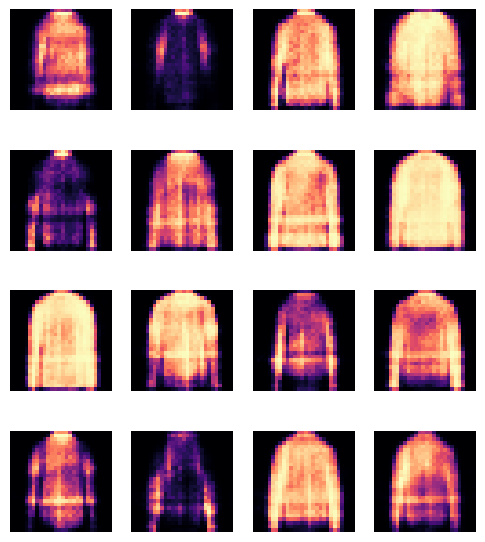

In [33]:
# Генерация

gen_and_show_cond(noise, generator_3, 4, cmap="magma")

Sandal


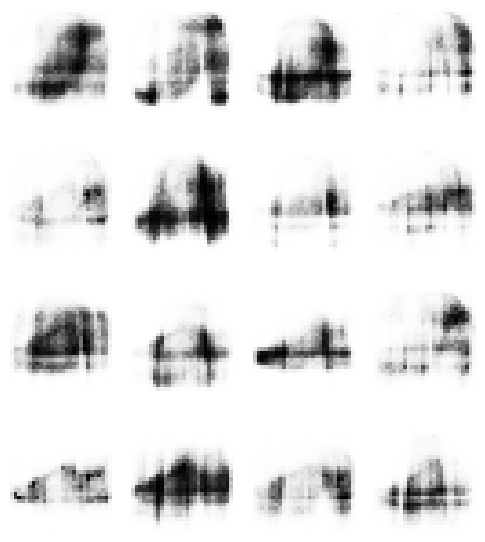

In [34]:
# Генерация

gen_and_show_cond(noise, generator_3, 5, cmap="Greys")

Shirt


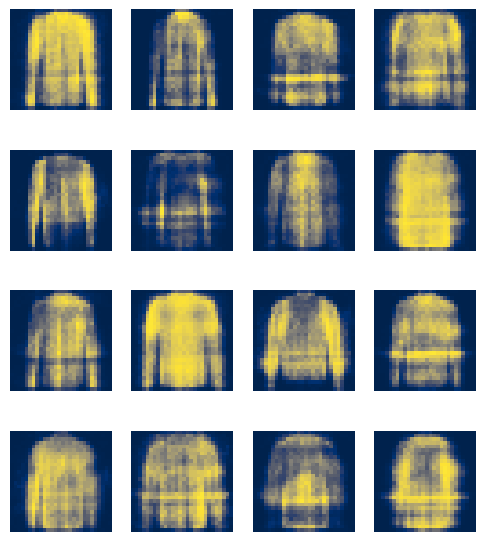

In [35]:
# Генерация

gen_and_show_cond(noise, generator_3, 6, cmap="cividis")

Sneaker


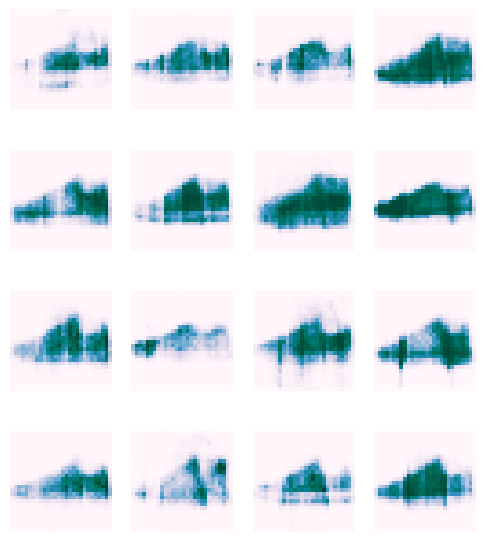

In [36]:
# Генерация

gen_and_show_cond(noise, generator_3, 7, cmap="PuBuGn")

Bag


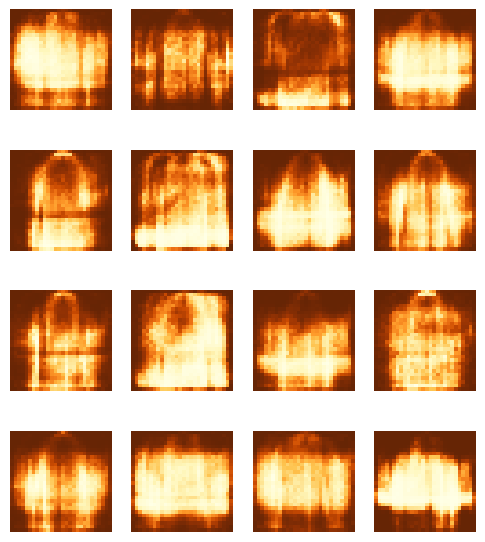

In [37]:
# Генерация

gen_and_show_cond(noise, generator_3, 8, cmap="YlOrBr_r")

Ankle Boot


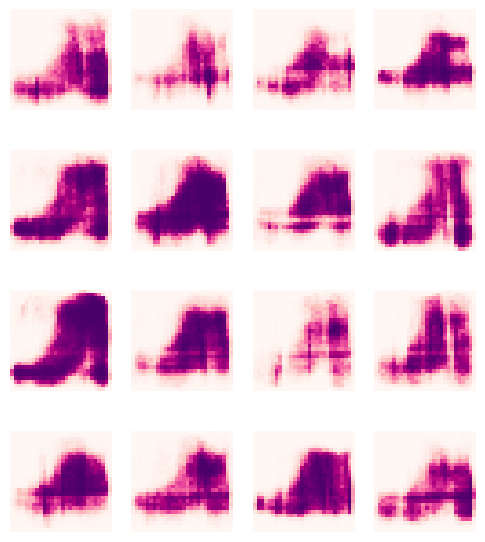

In [38]:
# Генерация

gen_and_show_cond(noise, generator_3, 9, cmap="RdPu")

Выводы, касающиеся СWGAN-GP:

1. Мы получили возможность осуществлять условную генерацию, что позволяет создавать конкретные типы изображений с помощью модели.
2. Сгенерированные изображения одного класса имеют достаточно большое разнообразие, но все же содержат повторяющиеся элементы.
3. Возможность получать много разных изображений одновременно благодаря внедрению условной генерации.

# Заключение


Итоговые результаты задания:

1. Генерация моделей:
Baseline - содержит шумы, но как базовая модель имеет свои преимущества.
WGAN+Clipping - хорошая детализация, но иногда не справляется с яркостью.
WGAN-GP - модель дает наиболее консистентные результаты с сохранением деталей, но часто приводит к размытию картинки.
CWGAN+GP - самая высокоуровневая генерация с наиболее четкими и местами разнообразными картинками, но самый долгий процесс обучения.


2. Плюсы и минусы моделей:
* Модели хорошо справляются с контурами и очертаниями.
* Бывают "артефакты" от других классов картинок.
* Присутствуют пересветы, недосветы и шумы.
* Наиболее сложно генерировать изображения обуви.
